# 1. 환경설정

## 1.1 필요 라이브러리 설치 및 import

In [27]:
%pip install pandas -q
%pip install ucimlrepo -q
%pip install koreanize-matplotlib -q
%pip install shap -q
%pip install statsmodels -q
%pip install missingno -q
%pip install squarify -q
%pip install xgboost -q
%pip install lightgbm -q



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To 

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib
import numpy as np
import missingno as msno

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

from statsmodels.graphics.mosaicplot import mosaic
import squarify

import matplotlib.font_manager as fm

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score

## 1.2 행 생략, 열 생략 방지 옵션

In [29]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## 1.3 한국어 매핑 딕셔너리

In [30]:
kor_mapping = {
    # 학생 정보 (Student Information)
    'Gender': '성별',
    'Nacionality': '국적',
    'Age at enrollment': '입학 시 나이',
    'Marital Status': '혼인 상태',
    'Application mode': '지원 방식',
    'Application order': '지원 순위',
    'Course': '전공 과정',
    'Daytime/evening attendance': '주간/야간 구분',
    'Previous qualification': '최종 학력',
    'International': '유학생 여부',
    'Displaced': '이주 여부',

    # 사회·경제적 변수(Socioeconomic)
    "Mother's qualification": '어머니 학력',
    "Father's qualification": '아버지 학력',
    "Mother's occupation": '어머니 직업',
    "Father's occupation": '아버지 직업',
    'Educational special needs': '특수 교육 필요 여부',
    'Debtor': '채무 여부',
    'Tuition fees up to date': '등록금 납부 최신 여부',
    'Scholarship holder': '장학금 수혜 여부',

    # 학업 관련 변수 (Academic performance) - 14개
    'Admission grade': '입학 성적',
    'Previous qualification (grade)': '이전 학력 성적',
    
    'Curricular units 1st sem (credited)': '1학기 이수 학점',
    'Curricular units 1st sem (enrolled)': '1학기 신청 학점',
    'Curricular units 1st sem (evaluations)': '1학기 평가 학점',
    'Curricular units 1st sem (approved)': '1학기 인정 학점',
    'Curricular units 1st sem (grade)': '1학기 평균 성적',
    'Curricular units 1st sem (without evaluations)': '1학기 미평가 학점',

    'Curricular units 2nd sem (credited)': '2학기 이수 학점',
    'Curricular units 2nd sem (enrolled)': '2학기 신청 학점',
    'Curricular units 2nd sem (evaluations)': '2학기 평가 학점',
    'Curricular units 2nd sem (approved)': '2학기 인정 학점',
    'Curricular units 2nd sem (grade)': '2학기 평균 성적',
    'Curricular units 2nd sem (without evaluations)': '2학기 미평가 학점',

    # 경제/사회 환경 변수 (Regional Socioeconomic Indicators)
    'Unemployment rate': '실업률',
    'Inflation rate': '물가상승률',
    'GDP': 'GDP',

    'Target': '학업 중단 여부'
}

In [31]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
  
# data (as pandas dataframes) 
X = predict_students_dropout_and_academic_success.data.features 
y = predict_students_dropout_and_academic_success.data.targets 
  
# metadata 
print(predict_students_dropout_and_academic_success.metadata) 


{'uci_id': 697, 'name': "Predict Students' Dropout and Academic Success", 'repository_url': 'https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success', 'data_url': 'https://archive.ics.uci.edu/static/public/697/data.csv', 'abstract': "A dataset created from a higher education institution (acquired from several disjoint databases) related to students enrolled in different undergraduate degrees, such as agronomy, design, education, nursing, journalism, management, social service, and technologies.\nThe dataset includes information known at the time of student enrollment (academic path, demographics, and social-economic factors) and the students' academic performance at the end of the first and second semesters. \nThe data is used to build classification models to predict students' dropout and academic sucess. The problem is formulated as a three category classification task, in which there is a strong imbalance towards one of the classes.", 'area': 'Social Sc

In [32]:
X = X.rename(columns=kor_mapping)
y = y.rename(columns=kor_mapping)

## 1.4 데이터 전처리

### 타겟 값 전처리 (학업 중단 / 학업 유지)

In [33]:
# 현재 값 확인
print("변환 전 값:")
print(y.value_counts())

# Enrolled 제외 - X와 y를 동일한 인덱스로 필터링
mask = (y.iloc[:, 0] != "Enrolled")  # DataFrame인 경우 첫 번째 컬럼 사용
X = X[mask].copy()
y = y[mask].copy()

print(f"\nEnrolled 제외 후 데이터 개수: {len(y)}")

# Series로 변환 (DataFrame이면)
if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]  # 첫 번째 컬럼만 가져오기

# Dropout → 1, Graduate → 0
y = (y == "Dropout").astype(int)

print(f"\n변환 후:")
print(f"총 데이터 개수: {len(y)}")
print(f"y 타입: {type(y)}")
print(f"유니크 값: {y.unique()}")
print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\n분포:")
print(y.value_counts().sort_index())
print(f"\n비율:")
print(y.value_counts(normalize=True).sort_index())

# 인덱스 리셋
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

변환 전 값:
학업 중단 여부
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

Enrolled 제외 후 데이터 개수: 3630

변환 후:
총 데이터 개수: 3630
y 타입: <class 'pandas.core.series.Series'>
유니크 값: [1 0]

X shape: (3630, 36)
y shape: (3630,)

분포:
학업 중단 여부
0    2209
1    1421
Name: count, dtype: int64

비율:
학업 중단 여부
0    0.60854
1    0.39146
Name: proportion, dtype: float64
X shape: (3630, 36)
y shape: (3630,)


## 1.5 전처리 전 kfold

In [34]:
# Train : Test = 8 : 2
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nTrain / Test 데이터셋 분할")
print("총 데이터 수 : ", len(X))
print(f"  - Train: {len(X_train):,}개 ({len(X_train)/len(X)*100:.1f}%)")
print(f"  - Test:  {len(X_test):,}개 ({len(X_test)/len(X)*100:.1f}%)")
print(f"\n타겟 분포 (Train):")
print(y_train.value_counts(normalize=True).sort_index())
print(f"\n타겟 분포 (Test):")
print(y_test.value_counts(normalize=True).sort_index())


Train / Test 데이터셋 분할
총 데이터 수 :  3630
  - Train: 2,904개 (80.0%)
  - Test:  726개 (20.0%)

타겟 분포 (Train):
학업 중단 여부
0    0.608471
1    0.391529
Name: proportion, dtype: float64

타겟 분포 (Test):
학업 중단 여부
0    0.608815
1    0.391185
Name: proportion, dtype: float64


In [35]:
# 스케일러
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# 스케일러
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
}

# K-Fold 교차검증
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("=" * 60)
print("K-Fold 교차검증 결과 (5-Fold)")
print("=" * 60)

cv_results = {}

for name, model in models.items():
    # 스케일링 필요한 모델
    if name == 'Logistic Regression':
        X_cv = X_train_scaled
    else:
        X_cv = X_train
    
    scores = cross_val_score(model, X_cv, y_train, cv=kfold, scoring='f1')
    cv_results[name] = scores
    
    print(f"\n{name}")
    print(f"  F1 Score: {scores.mean():.4f} (±{scores.std():.4f})")

# Test 데이터 최종 평가
print("\n" + "=" * 60)
print("Test 데이터 최종 평가")
print("=" * 60)

final_results = []

for name, model in models.items():
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    final_results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC-AUC': auc
    })
    
    print(f"\n{name}")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {auc:.4f}")

# 결과 비교표
results_df = pd.DataFrame(final_results)
results_df = results_df.sort_values('F1 Score', ascending=False).reset_index(drop=True)

print("\n" + "=" * 60)
print("모델 성능 비교 (F1 Score 기준 정렬)")
print("=" * 60)
print(results_df.to_string(index=False))

print(f"\n🏆 최고 성능 모델: {results_df.iloc[0]['Model']}")

K-Fold 교차검증 결과 (5-Fold)

Logistic Regression
  F1 Score: 0.8722 (±0.0116)

Decision Tree
  F1 Score: 0.8045 (±0.0063)



Random Forest
  F1 Score: 0.8654 (±0.0137)

XGBoost
  F1 Score: 0.8612 (±0.0134)

LightGBM
  F1 Score: 0.8663 (±0.0167)

Test 데이터 최종 평가

Logistic Regression
  Accuracy:  0.9421
  Precision: 0.9321
  Recall:    0.9190
  F1 Score:  0.9255
  ROC-AUC:   0.9733

Decision Tree
  Accuracy:  0.8471
  Precision: 0.7729
  Recall:    0.8627
  F1 Score:  0.8153
  ROC-AUC:   0.8499

Random Forest
  Accuracy:  0.9201
  Precision: 0.9185
  Recall:    0.8732
  F1 Score:  0.8953
  ROC-AUC:   0.9705

XGBoost
  Accuracy:  0.9201
  Precision: 0.9065
  Recall:    0.8873
  F1 Score:  0.8968
  ROC-AUC:   0.9697

LightGBM
  Accuracy:  0.9270
  Precision: 0.9170
  Recall:    0.8944
  F1 Score:  0.9055
  ROC-AUC:   0.9718

모델 성능 비교 (F1 Score 기준 정렬)
              Model  Accuracy  Precision   Recall  F1 Score  ROC-AUC
Logistic Regression  0.942149   0.932143 0.919014  0.925532 0.973305
           LightGBM  0.926997   0.916968 0.894366  0.905526 0.971775
            XGBoost  0.920110   0.906475 0.887324  0.896797

## 1.6 부모 정보 컬럼 범주화

In [36]:
# 학력
dad_edu_map = {
    # Level 0 — 무학/문해
    35: 0, 36: 0,

    # Level 1 — 기초·중등 미완료
    11: 1, 26: 1, 30: 1, 37: 1, 38: 1,
    29: 1, 10: 1, 9: 1,

    # Level 2 — 중등(고교)
    1: 2, 14: 2, 19: 2, 12: 2, 13: 2,
    20: 2, 25: 2, 18: 2, 22: 2, 31: 2,
    33: 2, 27: 2,

    # Level 3 — 고등교육
    2: 3, 3: 3, 6: 3, 40: 3, 39: 3, 41: 3, 42: 3,

    # Level 4 — 석·박사
    4: 4, 5: 4, 43: 4, 44: 4,

    # Unknown
    34: 9
}

X['아버지 학력'] = X['아버지 학력'].map(dad_edu_map)

# 학력
mom_edu_map = {
    # Level 0
    35: 0, 36: 0,

    # Level 1 — 기초·중등 미완료
    11: 1, 26: 1, 30: 1, 37: 1, 38: 1,
    29: 1, 10: 1, 9: 1,

    # Level 2 — 중등(고교)
    1: 2, 14: 2, 19: 2,
    18: 2, 22: 2, 27: 2,
    12: 2,

    # Level 3 — 고등교육
    2: 3, 3: 3, 6: 3,
    39: 3, 40: 3, 41: 3, 42: 3,

    # Level 4 — 석·박사
    4: 4, 5: 4, 43: 4, 44: 4,

    # Unknown
    34: 9
}

X['어머니 학력'] = X['어머니 학력'].map(mom_edu_map)

# 직업
mom_job_level = {
    # 0 — 학생
    0: 0,

    # 1 — 관리자/임원 → 최상위 직군
    1: 9,

    # 2 — 전문직
    2: 8, 122: 8, 123: 8, 125: 8,

    # 3 — 중급 전문/기술직
    3: 7, 131: 7, 132: 7, 134: 7,

    # 4 — 사무/행정직
    4: 6, 141: 6, 143: 6, 144: 6,

    # 5 — 서비스·판매·돌봄직
    5: 5, 151: 5, 152: 5, 153: 5,

    # 6 — 농림어업
    6: 3,

    # 7 — 산업·건설·생산·기계직
    7: 4, 8: 4, 171: 4, 173: 4,
    175: 4, 181: 4, 182: 4, 183: 4,
    192: 4, 193: 4, 194: 4,

    # 8 — 비숙련 노동자
    9: 2, 191: 2,

    # 군 관련 직종은 별도로 4~5단계 성격 → 생산직과 유사  
    10: 4,

    # 기타/무응답
    90: 1,
    99: 1
}

X['어머니 직업'] = X['어머니 직업'].map(mom_job_level)

# 직업
dad_job_level = {
    # 학생
    0: 0,

    # 기타 / 무응답
    90: 1,
    99: 1,

    # 관리자·임원
    1: 9, 112: 9, 114: 9,

    # 전문직
    2: 8, 121: 8, 122: 8, 123: 8, 124: 8,

    # 중급 전문/기술직
    3: 7, 131: 7, 132: 7, 134: 7, 135: 7,

    # 사무/행정직
    4: 6, 141: 6, 143: 6, 144: 6,

    # 서비스·판매·돌봄·보안
    5: 5, 151: 5, 152: 5, 153: 5, 154: 5, 195: 5,

    # 농림어업
    6: 3, 161: 3, 163: 3,

    # 산업·건설·생산직
    7: 4, 8: 4,
    171: 4, 172: 4, 174: 4, 175: 4,
    181: 4, 182: 4, 183: 4,
    193: 4, 194: 4,

    # 비숙련 노동자
    9: 2, 191: 2, 192: 2,

    # 군 관련 직종
    10: 4, 101: 4, 102: 4, 103: 4  
}

X['아버지 직업'] = X['아버지 직업'].map(dad_job_level)


# 2. feature engineering

## 2.1 파생 변수 생성

In [37]:
# 미혼 여부: 미혼(1) → 1, 나머지 → 0
X['미혼 여부'] = X['혼인 상태'].apply(lambda x: 1 if x == 1 else 0)

# 학업 관련 변화량 추가
X['평가학점 변화량'] = X['2학기 평가 학점'] - X['1학기 평가 학점']
X['인정학점 변화량'] = X['2학기 인정 학점'] - X['1학기 인정 학점']
X['평균성적 변화량'] = X['2학기 평균 성적'] - X['1학기 평균 성적']

def make_direction_label(series):
    return np.where(series < 0, 0,      # 감소=0
           np.where(series > 0, 2, 1))  # 증가=2, 유지=1

X['평가학점 변화방향'] = make_direction_label(X['평가학점 변화량'])
X['인정학점 변화방향'] = make_direction_label(X['인정학점 변화량'])
X['평균성적 변화방향'] = make_direction_label(X['평균성적 변화량'])


## 2.2 필요 없는 컬럼 삭제

In [38]:
del_col = [
            "혼인 상태", "주간/야간 구분", "최종 학력", "유학생 여부", "이주 여부", "특수 교육 필요 여부",
            "이전 학력 성적", "1학기 이수 학점", "2학기 이수 학점", "1학기 미평가 학점", "2학기 미평가 학점", "1학기 평가 학점", "2학기 평가 학점",
            "실업률", "물가상승률", "GDP"
        ]

X = X.drop(del_col, axis=1)

In [39]:
print(X.shape)
X.columns

(3630, 27)


Index(['지원 방식', '지원 순위', '전공 과정', '국적', '어머니 학력', '아버지 학력', '어머니 직업', '아버지 직업',
       '입학 성적', '채무 여부', '등록금 납부 최신 여부', '성별', '장학금 수혜 여부', '입학 시 나이',
       '1학기 신청 학점', '1학기 인정 학점', '1학기 평균 성적', '2학기 신청 학점', '2학기 인정 학점',
       '2학기 평균 성적', '미혼 여부', '평가학점 변화량', '인정학점 변화량', '평균성적 변화량', '평가학점 변화방향',
       '인정학점 변화방향', '평균성적 변화방향'],
      dtype='object')

# 3. train / test 분리

In [40]:
# Train : Test = 8 : 2
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nTrain / Test 데이터셋 분할")
print("총 데이터 수 : ", len(X))
print(f"  - Train: {len(X_train):,}개 ({len(X_train)/len(X)*100:.1f}%)")
print(f"  - Test:  {len(X_test):,}개 ({len(X_test)/len(X)*100:.1f}%)")
print(f"\n타겟 분포 (Train):")
print(y_train.value_counts(normalize=True).sort_index())
print(f"\n타겟 분포 (Test):")
print(y_test.value_counts(normalize=True).sort_index())


Train / Test 데이터셋 분할
총 데이터 수 :  3630
  - Train: 2,904개 (80.0%)
  - Test:  726개 (20.0%)

타겟 분포 (Train):
학업 중단 여부
0    0.608471
1    0.391529
Name: proportion, dtype: float64

타겟 분포 (Test):
학업 중단 여부
0    0.608815
1    0.391185
Name: proportion, dtype: float64


In [41]:
print(X_train.shape[1], "개의 컬럼")
X_train.columns

27 개의 컬럼


Index(['지원 방식', '지원 순위', '전공 과정', '국적', '어머니 학력', '아버지 학력', '어머니 직업', '아버지 직업',
       '입학 성적', '채무 여부', '등록금 납부 최신 여부', '성별', '장학금 수혜 여부', '입학 시 나이',
       '1학기 신청 학점', '1학기 인정 학점', '1학기 평균 성적', '2학기 신청 학점', '2학기 인정 학점',
       '2학기 평균 성적', '미혼 여부', '평가학점 변화량', '인정학점 변화량', '평균성적 변화량', '평가학점 변화방향',
       '인정학점 변화방향', '평균성적 변화방향'],
      dtype='object')

## 3.1 K-fold cross validation

In [42]:
# 2. 스케일링 (Train 기준)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
}

# K-Fold 교차검증
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("=" * 60)
print("K-Fold 교차검증 결과 (5-Fold)")
print("=" * 60)

cv_results = {}

for name, model in models.items():
    # 스케일링 필요한 모델
    if name == 'Logistic Regression':
        X_cv = X_train_scaled
    else:
        X_cv = X_train
    
    scores = cross_val_score(model, X_cv, y_train, cv=kfold, scoring='f1')
    cv_results[name] = scores
    
    print(f"\n{name}")
    print(f"  F1 Score: {scores.mean():.4f} (±{scores.std():.4f})")

# Test 데이터 최종 평가
print("\n" + "=" * 60)
print("Test 데이터 최종 평가")
print("=" * 60)

final_results = []

for name, model in models.items():
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    final_results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC-AUC': auc
    })
    
    print(f"\n{name}")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {auc:.4f}")

# 결과 비교표
results_df = pd.DataFrame(final_results)
results_df = results_df.sort_values('F1 Score', ascending=False).reset_index(drop=True)

print("\n" + "=" * 60)
print("모델 성능 비교 (F1 Score 기준 정렬)")
print("=" * 60)
print(results_df.to_string(index=False))

print(f"\n🏆 최고 성능 모델: {results_df.iloc[0]['Model']}")

K-Fold 교차검증 결과 (5-Fold)

Logistic Regression
  F1 Score: 0.8699 (±0.0151)

Decision Tree
  F1 Score: 0.7923 (±0.0134)

Random Forest
  F1 Score: 0.8588 (±0.0113)

XGBoost
  F1 Score: 0.8582 (±0.0115)

LightGBM
  F1 Score: 0.8632 (±0.0103)

Test 데이터 최종 평가

Logistic Regression
  Accuracy:  0.9380
  Precision: 0.9253
  Recall:    0.9155
  F1 Score:  0.9204
  ROC-AUC:   0.9716

Decision Tree
  Accuracy:  0.8554
  Precision: 0.7934
  Recall:    0.8521
  F1 Score:  0.8217
  ROC-AUC:   0.8548

Random Forest
  Accuracy:  0.9229
  Precision: 0.9254
  Recall:    0.8732
  F1 Score:  0.8986
  ROC-AUC:   0.9667

XGBoost
  Accuracy:  0.9242
  Precision: 0.8962
  Recall:    0.9120
  F1 Score:  0.9040
  ROC-AUC:   0.9674

LightGBM
  Accuracy:  0.9366
  Precision: 0.9220
  Recall:    0.9155
  F1 Score:  0.9187
  ROC-AUC:   0.9703

모델 성능 비교 (F1 Score 기준 정렬)
              Model  Accuracy  Precision   Recall  F1 Score  ROC-AUC
Logistic Regression  0.938017   0.925267 0.915493  0.920354 0.971616
          

### (폐기) 원핫인코딩 수행

In [43]:
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from sklearn.model_selection import StratifiedKFold, cross_val_score
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# # 1. 원핫인코딩 수행
# # X_train과 X_test가 pandas DataFrame이라고 가정합니다.
# X_train_encoded = pd.get_dummies(X_train, drop_first=True)
# X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# # 훈련 세트와 테스트 세트의 컬럼을 일치시킵니다.
# # 테스트 세트에 없는 훈련 세트 컬럼은 0으로 채우고, 훈련 세트에 없는 테스트 세트 컬럼은 제거합니다.
# train_cols = X_train_encoded.columns
# test_cols = X_test_encoded.columns

# missing_in_test = set(train_cols) - set(test_cols)
# for c in missing_in_test:
#     X_test_encoded[c] = 0

# missing_in_train = set(test_cols) - set(train_cols)
# for c in missing_in_train:
#     X_train_encoded[c] = 0

# X_test_encoded = X_test_encoded[train_cols] # 컬럼 순서와 존재 여부를 훈련 세트와 일치시킵니다.

# # 인코딩된 데이터를 원본 변수에 할당하여 이후 과정에서 사용합니다.
# X_train = X_train_encoded
# X_test = X_test_encoded

# # 2. 스케일링 (Train 기준)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# models = {
#     'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
#     'Decision Tree': DecisionTreeClassifier(random_state=42),
#     'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
#     'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
#     'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
# }

# # K-Fold 교차검증
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# print("=" * 60)
# print("K-Fold 교차검증 결과 (5-Fold)")
# print("=" * 60)

# cv_results = {}

# for name, model in models.items():
#     # 스케일링 필요한 모델
#     if name == 'Logistic Regression':
#         X_cv = X_train_scaled
#     else:
#         X_cv = X_train
    
#     scores = cross_val_score(model, X_cv, y_train, cv=kfold, scoring='f1')
#     cv_results[name] = scores
    
#     print(f"\n{name}")
#     print(f"  F1 Score: {scores.mean():.4f} (±{scores.std():.4f})")

# # Test 데이터 최종 평가
# print("\n" + "=" * 60)
# print("Test 데이터 최종 평가")
# print("=" * 60)

# final_results = []

# for name, model in models.items():
#     if name == 'Logistic Regression':
#         model.fit(X_train_scaled, y_train)
#         y_pred = model.predict(X_test_scaled)
#         y_prob = model.predict_proba(X_test_scaled)[:, 1]
#     else:
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         y_prob = model.predict_proba(X_test)[:, 1]
    
#     acc = accuracy_score(y_test, y_pred)
#     prec = precision_score(y_test, y_pred)
#     rec = recall_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
#     auc = roc_auc_score(y_test, y_prob)
    
#     final_results.append({
#         'Model': name,
#         'Accuracy': acc,
#         'Precision': prec,
#         'Recall': rec,
#         'F1 Score': f1,
#         'AUC': auc
#     })

# final_df = pd.DataFrame(final_results)
# print(final_df)

In [44]:
from sklearn.metrics import log_loss

# 기존 모델 사용 (model → log_model로 rename)
log_model = model  

# log-likelihood 계산
ll_full = -log_loss(y_train, log_model.predict_proba(X_train), normalize=False)

# null 모델
p_null = y_train.mean()
ll_null = -log_loss(y_train, [p_null] * len(y_train), normalize=False)

# McFadden's Pseudo R²
mcfadden_r2 = 1 - (ll_full / ll_null)

print(f"McFadden's Pseudo R²: {mcfadden_r2:.4f}")

McFadden's Pseudo R²: 0.9134


## 3.2 Confusion Matrix (로지스틱 회귀 분석)

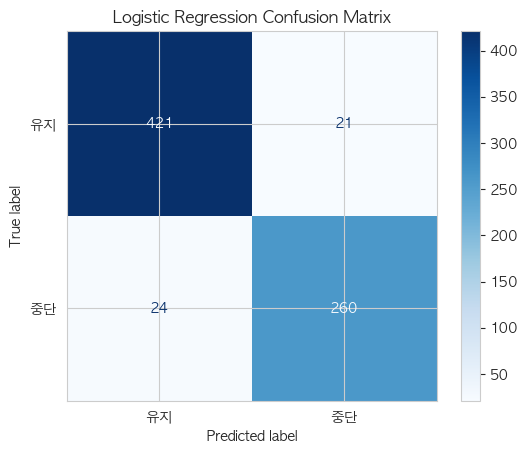

         Feature  Coefficient
18     2학기 인정 학점     2.282911
15     1학기 인정 학점     2.171414
17     2학기 신청 학점     1.360995
14     1학기 신청 학점     1.288261
10  등록금 납부 최신 여부     0.759553
19     2학기 평균 성적     0.447471
23      평균성적 변화량     0.397920
9          채무 여부     0.349580
12     장학금 수혜 여부     0.315110
16     1학기 평균 성적     0.255123


In [45]:
# 1. Confusion Matrix 시각화
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Logistic Regression 최종 모델
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['유지', '중단'])
disp.plot(cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# 2. Feature Importance (계수 크기)
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': abs(model.coef_[0])
}).sort_values('Coefficient', ascending=False)

print(importance.head(10))

## 3.3 Feature importance

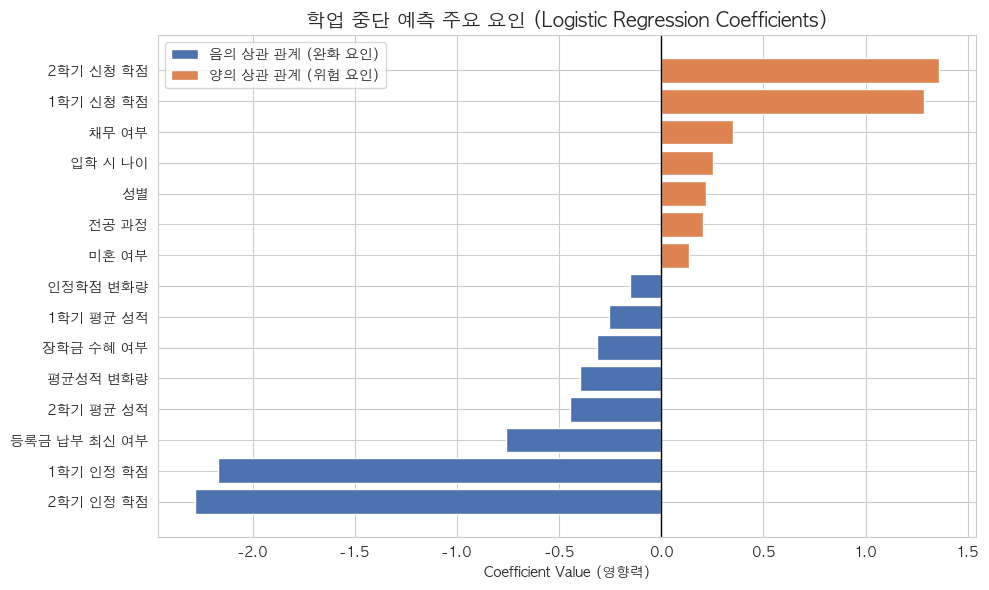

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importance (계수)
coef = model.coef_[0]
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coef
})

# 절댓값 기준 상위 N개 선택
N = 15
top_features = importance.reindex(importance['Coefficient'].abs().sort_values(ascending=False).index).head(N)

# 양수 / 음수 분리
top_features = top_features.sort_values('Coefficient')
neg = top_features[top_features['Coefficient'] < 0]
pos = top_features[top_features['Coefficient'] > 0]

plt.figure(figsize=(10, 6))

# 1. 스타일 설정
sns.set_style("whitegrid")

# 2. 폰트 설정 (반드시 스타일 설정 다음에!)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 음수 계수 (왼쪽)
plt.barh(neg['Feature'], neg['Coefficient'], color='#4C72B0', label='음의 상관 관계 (완화 요인)')

# 양수 계수 (오른쪽)
plt.barh(pos['Feature'], pos['Coefficient'], color='#DD8452', label='양의 상관 관계 (위험 요인)')

plt.title("학업 중단 예측 주요 요인 (Logistic Regression Coefficients)", fontsize=14, fontweight='bold')
plt.xlabel("Coefficient Value (영향력)")
plt.axvline(0, color='black', linewidth=1)
plt.legend()

plt.tight_layout()
plt.show()

오즈비 (Odds Ratio) 해석

위험 요인 TOP 15 (오즈비 > 1)
----------------------------------------------------------------------
2학기 신청 학점                      | OR=3.900 → 중단 위험 +290.0% 증가
1학기 신청 학점                      | OR=3.626 → 중단 위험 +262.6% 증가
채무 여부                          | OR=1.418 → 중단 위험 +41.8% 증가
입학 시 나이                        | OR=1.286 → 중단 위험 +28.6% 증가
성별                             | OR=1.245 → 중단 위험 +24.5% 증가
전공 과정                          | OR=1.226 → 중단 위험 +22.6% 증가
미혼 여부                          | OR=1.146 → 중단 위험 +14.6% 증가
평가학점 변화방향                      | OR=1.092 → 중단 위험 +9.2% 증가
지원 방식                          | OR=1.077 → 중단 위험 +7.7% 증가
아버지 학력                         | OR=1.071 → 중단 위험 +7.1% 증가
평균성적 변화방향                      | OR=1.062 → 중단 위험 +6.2% 증가
지원 순위                          | OR=1.059 → 중단 위험 +5.9% 증가
아버지 직업                         | OR=1.052 → 중단 위험 +5.2% 증가
어머니 학력                         | OR=1.043 → 중단 위험 +4.3% 증가
국적                             | OR=1.027 → 중단 위험 

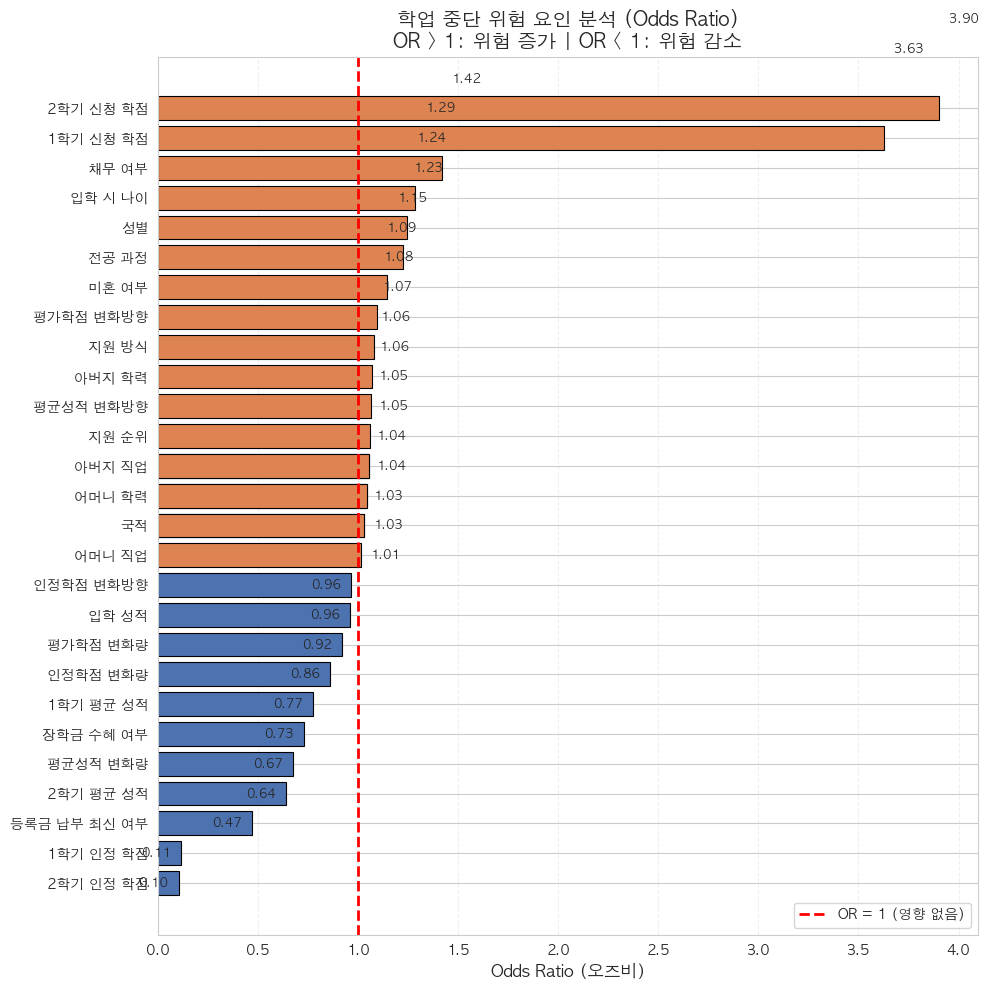

In [47]:
import numpy as np
import pandas as pd

# 1. 오즈비 계산
odds_ratios = np.exp(model.coef_[0])

# 2. DataFrame으로 정리 (해석하기 쉽게)
odds_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_[0],
    'Odds_Ratio': odds_ratios
}).sort_values('Odds_Ratio', ascending=False)

# 3. 상위/하위 15개 출력
print("="*70)
print("오즈비 (Odds Ratio) 해석")
print("="*70)
print("\n위험 요인 TOP 15 (오즈비 > 1)")
print("-" * 70)
top_risk = odds_df[odds_df['Odds_Ratio'] > 1].head(15)
for idx, row in top_risk.iterrows():
    feature = row['Feature']
    or_val = row['Odds_Ratio']
    increase_pct = (or_val - 1) * 100
    print(f"{feature:30s} | OR={or_val:.3f} → 중단 위험 {increase_pct:+.1f}% 증가")

print("\n보호 요인 TOP 15 (오즈비 < 1)")
print("-" * 70)
top_protect = odds_df[odds_df['Odds_Ratio'] < 1].tail(15).iloc[::-1]
for idx, row in top_protect.iterrows():
    feature = row['Feature']
    or_val = row['Odds_Ratio']
    decrease_pct = (1 - or_val) * 100
    print(f"{feature:30s} | OR={or_val:.3f} → 중단 위험 {decrease_pct:.1f}% 감소")

# 4. 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 상위/하위 각 15개
N = 15
top_features = pd.concat([
    odds_df.head(N),  # 위험 요인
    odds_df.tail(N)   # 보호 요인
]).sort_values('Odds_Ratio')

# 색상: OR > 1 (위험) = 주황, OR < 1 (보호) = 파랑
colors = ['#DD8452' if x > 1 else '#4C72B0' for x in top_features['Odds_Ratio']]

fig, ax = plt.subplots(figsize=(10, 10))
bars = ax.barh(top_features['Feature'], top_features['Odds_Ratio'], 
               color=colors, edgecolor='black', linewidth=0.8)

# 기준선 (OR = 1)
ax.axvline(1, color='red', linestyle='--', linewidth=2, label='OR = 1 (영향 없음)')

# 값 표시
for i, (idx, row) in enumerate(top_features.iterrows()):
    or_val = row['Odds_Ratio']
    x_pos = or_val + (0.05 if or_val > 1 else -0.05)
    ha = 'left' if or_val > 1 else 'right'
    ax.text(x_pos, i, f'{or_val:.2f}', va='center', ha=ha, 
            fontsize=9, fontweight='bold')

ax.set_xlabel('Odds Ratio (오즈비)', fontsize=12, fontweight='bold')
ax.set_title('학업 중단 위험 요인 분석 (Odds Ratio)\nOR > 1: 위험 증가 | OR < 1: 위험 감소', 
             fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

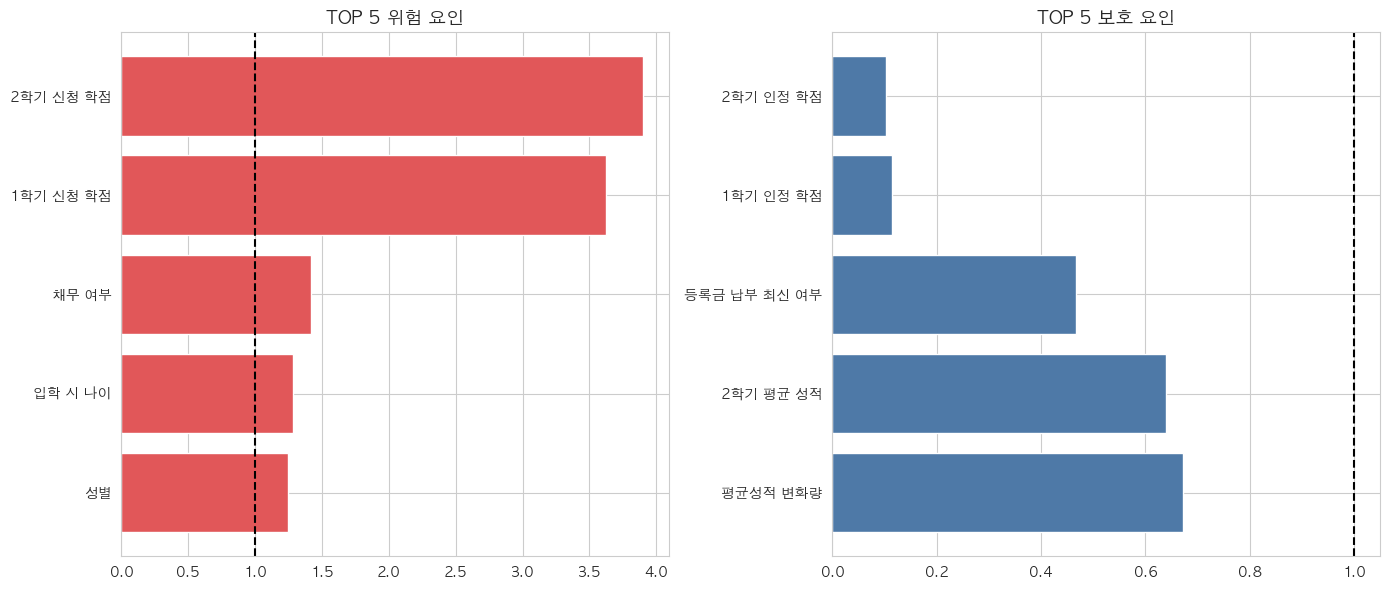

In [48]:
top5_risk = odds_df[odds_df['Odds_Ratio'] > 1].sort_values('Odds_Ratio', ascending=False).head(5)
top5_protect = odds_df[odds_df['Odds_Ratio'] < 1].sort_values('Odds_Ratio').head(5)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 위험
axes[0].barh(top5_risk['Feature'], top5_risk['Odds_Ratio'], color='#E15759')
axes[0].invert_yaxis()
axes[0].set_title('TOP 5 위험 요인', fontsize=13)
axes[0].axvline(1, linestyle='--', color='black')

# 보호
axes[1].barh(top5_protect['Feature'], top5_protect['Odds_Ratio'], color='#4E79A7')
axes[1].invert_yaxis()
axes[1].set_title('TOP 5 보호 요인', fontsize=13)
axes[1].axvline(1, linestyle='--', color='black')

plt.tight_layout()
plt.show()

In [49]:
X.columns

Index(['지원 방식', '지원 순위', '전공 과정', '국적', '어머니 학력', '아버지 학력', '어머니 직업', '아버지 직업',
       '입학 성적', '채무 여부', '등록금 납부 최신 여부', '성별', '장학금 수혜 여부', '입학 시 나이',
       '1학기 신청 학점', '1학기 인정 학점', '1학기 평균 성적', '2학기 신청 학점', '2학기 인정 학점',
       '2학기 평균 성적', '미혼 여부', '평가학점 변화량', '인정학점 변화량', '평균성적 변화량', '평가학점 변화방향',
       '인정학점 변화방향', '평균성적 변화방향'],
      dtype='object')

## add. pca로 변수 추가 후 성능 향상 확인 (감소함)

In [50]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd

# ================================
# 1) PCA 적용할 성적 변수
# ================================
grade_cols = [
    '1학기 인정 학점', '1학기 평균 성적',
    '2학기 인정 학점', '2학기 평균 성적',
]

other_cols = [col for col in X.columns if col not in grade_cols]

# PCA 변환기
grade_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2, random_state=42))
])

# ColumnTransformer 구성
preprocessor = ColumnTransformer(
    transformers=[
        ('grade_pca', grade_transformer, grade_cols),
        ('other', 'passthrough', other_cols)
    ]
)

# ================================
# 2) 모델 정의
# ================================
models = {
    "Logistic (No PCA)": LogisticRegression(max_iter=2000),
    "Logistic (PCA)": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('log_reg', LogisticRegression(max_iter=2000))
    ]),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "XGBoost": XGBClassifier(n_estimators=200, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(n_estimators=200)
}

# ================================
# 3) K-Fold 세팅
# ================================
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

# ================================
# 4) 모든 모델 K-Fold 교차검증
# ================================
for name, model in models.items():
    print(f"\n▶ {name} K-Fold 진행 중...\n")

    # PCA 모델은 X 그대로 사용 (파이프라인 안에서 전처리됨)
    # 일반 모델은 원본 X 사용
    X_for_cv = X  

    scores = cross_val_score(model, X_for_cv, y, cv=kfold, scoring='f1')
    
    results.append([name, scores.mean(), scores.std()])
    
    print(f"{name} 평균 F1: {scores.mean():.4f}")
    print(f"{name} 표준편차: {scores.std():.4f}")

# ================================
# 5) 결과 DataFrame 정리
# ================================
df_result = pd.DataFrame(results, columns=["Model", "F1 Mean", "F1 Std"])
print("\n==============================")
print("PCA 포함 모델 성능 비교 결과")
print("==============================")
print(df_result.sort_values("F1 Mean", ascending=False))

# ================================
# 6) Test 데이터 최종 평가
# ================================
print("\n==============================")
print("Test 데이터 평가 시작")
print("==============================")

for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(f"\n===== {name} =====")
    print(classification_report(y_test, pred))


▶ Logistic (No PCA) K-Fold 진행 중...

Logistic (No PCA) 평균 F1: 0.8784
Logistic (No PCA) 표준편차: 0.0112

▶ Logistic (PCA) K-Fold 진행 중...

Logistic (PCA) 평균 F1: 0.8739
Logistic (PCA) 표준편차: 0.0139

▶ Random Forest K-Fold 진행 중...

Random Forest 평균 F1: 0.8658
Random Forest 표준편차: 0.0170

▶ XGBoost K-Fold 진행 중...

XGBoost 평균 F1: 0.8754
XGBoost 표준편차: 0.0155

▶ LightGBM K-Fold 진행 중...

LightGBM 평균 F1: 0.8721
LightGBM 표준편차: 0.0125

PCA 포함 모델 성능 비교 결과
               Model   F1 Mean    F1 Std
0  Logistic (No PCA)  0.878370  0.011244
3            XGBoost  0.875365  0.015498
1     Logistic (PCA)  0.873882  0.013947
4           LightGBM  0.872100  0.012473
2      Random Forest  0.865835  0.017046

Test 데이터 평가 시작

===== Logistic (No PCA) =====
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       442
           1       0.92      0.91      0.91       284

    accuracy                           0.93       726
   macro avg       0.93      0.93      0.93    

In [51]:
# Best Model 출력
best_idx = df_result['F1 Mean'].idxmax()
best_model_name = df_result.loc[best_idx, 'Model']

print(f"Best Model: {best_model_name}")

Best Model: Logistic (No PCA)


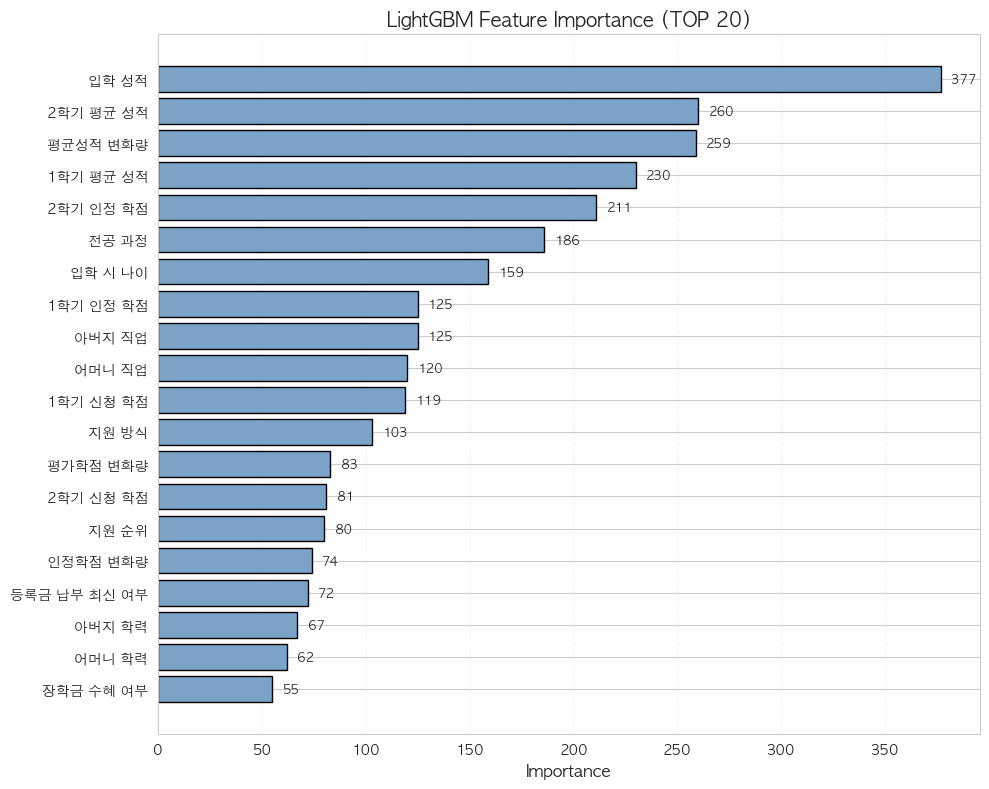

In [52]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. LightGBM 모델 학습 (이미 학습했다면 생략)
lgbm_model = LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
lgbm_model.fit(X_train, y_train)

# 2. Feature Importance 추출
importance = lgbm_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values('Importance', ascending=False)
# 상위 N개만 선택
top_n = 20
importance_df_top = importance_df.head(top_n).sort_values('Importance')
# 3. 시각화
plt.figure(figsize=(10, 8))
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
bars = plt.barh(range(len(importance_df_top)), importance_df_top['Importance'],
                color='#7BA3C7', edgecolor='black', linewidth=1)
# 값 표시
for i, (idx, row) in enumerate(importance_df_top.iterrows()):
    plt.text(row['Importance'] + 5, i, f"{int(row['Importance'])}", 
             va='center', fontsize=9, fontweight='bold')
plt.yticks(range(len(importance_df_top)), importance_df_top['Feature'], fontsize=10)
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.title(f'LightGBM Feature Importance (TOP {top_n})', 
          fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.2, linestyle='--')
plt.tight_layout()
plt.show()